# 3-6. 프로젝트: 고양이 수염 스티커 만들기

### Step 1. 스티커 구하기 or 만들기

(1) 고양이 수염 이미지를 다운로드 받아주세요.

(2) 여러분의 셀카 이미지도 촬영해 주세요.

#### flaticon 사이트에 공개되어있는 고양이 수염 이미지를 다운받아 두었고, 제 사진도 촬영해 두었습니다.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
print("🌫🛸")

🌫🛸


이미지 처리를 위해 matplptlib를 읽어옵니다

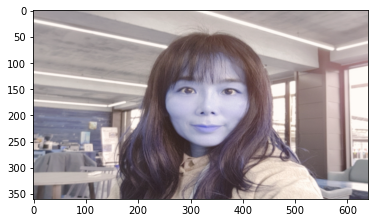

In [2]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

셀카 이미지를 불러옵니다. opencv의 특성상 이미지 채널을 BGR(파랑,녹색,빨강)순으로 사용하기 때문에 원본 사진에서 붉은색은 푸른색으로, 푸른색은 붉은색으로 바뀌어 출력 됩니다.

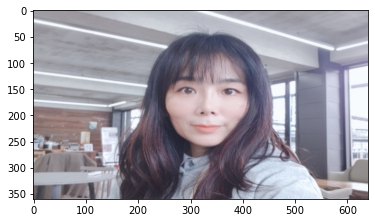

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

이미지 채널을 RGB(빨강, 녹색, 파랑) 으로 조정했습니다. 색상이 다시 원위치 됬네요

### Step 2. 얼굴 검출 & 랜드마크 검출 하기

오늘 배운 dlib을 이용해서 얼굴의 bounding box 위치와 landmark의 위치를 찾아주세요.

In [4]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

🌫🛸


 이미지 밝기에 관계없이 이미지의 주요 특징들을 캡처한 HOG 패턴으로 바꿔줍니다.

In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환해 주었습니다.

rectangles[[(253, 116) (408, 270)]]


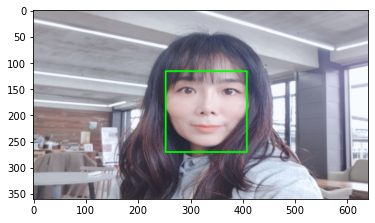

In [6]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [7]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


랜드마크 모델을 불러옵니다.

In [8]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


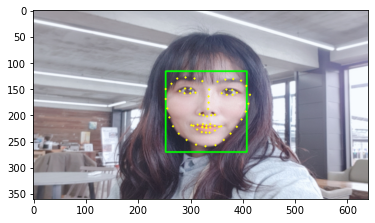

In [9]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

68개의 랜드마크가 정확하게 출력이 되었네요.

#### HOG(Histogram of Oriented Gradient) feature를 사용해서 SVM(Support Vector Machine)의 sliding window로 얼굴을 찾는 dlib 의 face detector를 이용해 얼굴을 검출하고, Dlib의 저장한 landmark 모델을 활용해서 68개의 랜드마크를 출력해 보았습니다

### Step 3. 스티커 적용 위치 확인하기

고양이 수염이 적용 될 볼 위치를 landmark를 사용해서 계산해 주세요.

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width() // 2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(334, 188)
(x,y) : (334,110)
(w,h) : (156,156)


좌표를 확인해보니 코의 중심점이 (334,188)로 나오네요.

In [11]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(156, 156, 3)


콧수염 이미지를 resize 합니다.

In [12]:
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (256,-46)


In [13]:
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(110, 156, 3)


원본이미지에 스티커 이미지를 추가하기 위해서 x,y 좌표를 조정합니다.

In [14]:
refined_y = 150
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (256,150)


In [15]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)


#refined_y:refined_y+img_stricker.shape[0]으로 sticker_area, img_show

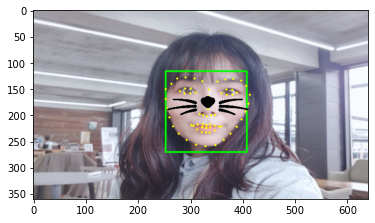

In [16]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

고양이 수염이 아주 귀엽게 장착이 되었네요

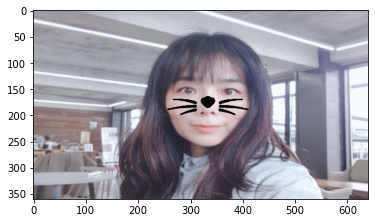

In [17]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

bounding box와 landmark를 제거하고 최종 결과만 출력해 완성되었습니다.

### Step 5. 문제점 찾아보기

(1) 셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해 보세요.

(2) 문제점이 무엇인지 최대한 자세하게 기록해 보세요. 여러분이 생각한 문제점을 해결하기 위한 방법은 분명 존재합니다!

#### 측면 얼굴에 스티커 적용해보기

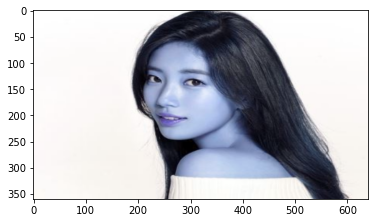

In [18]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/suji.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

셀카 이미지를 불러옵니다. opencv의 특성상 이미지 채널을 BGR(파랑,녹색,빨강)순으로 사용하기 때문에 원본 사진에서 붉은색은 푸른색으로, 푸른색은 붉은색으로 바뀌어 출력 됩니다.

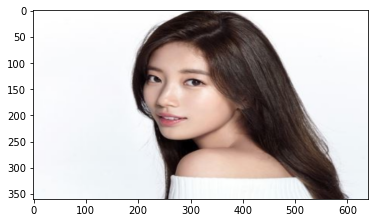

In [19]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

이미지 채널을 RGB(빨강, 녹색, 파랑) 으로 조정했습니다. 색상이 다시 원위치 됬네요

### Step 2. 얼굴 검출 & 랜드마크 검출 하기

오늘 배운 dlib을 이용해서 얼굴의 bounding box 위치와 landmark의 위치를 찾아주세요.

In [20]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

🌫🛸


 이미지 밝기에 관계없이 이미지의 주요 특징들을 캡처한 HOG 패턴으로 바꿔줍니다.

In [21]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환해 주었습니다.

rectangles[[(184, 81) (339, 236)]]


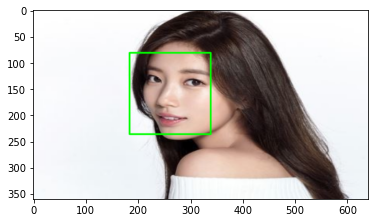

In [22]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [23]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


랜드마크 모델을 불러옵니다.

In [24]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


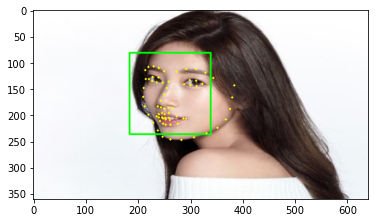

In [25]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

68개의 랜드마크가 정확하게 출력이 되었네요.

#### HOG(Histogram of Oriented Gradient) feature를 사용해서 SVM(Support Vector Machine)의 sliding window로 얼굴을 찾는 dlib 의 face detector를 이용해 얼굴을 검출하고, Dlib의 저장한 landmark 모델을 활용해서 68개의 랜드마크를 출력해 보았습니다

### Step 3. 스티커 적용 위치 확인하기

고양이 수염이 적용 될 볼 위치를 landmark를 사용해서 계산해 주세요.

In [26]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width() // 2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(244, 172)
(x,y) : (244,94)
(w,h) : (156,156)


좌표를 확인해보니 코의 중심점이 (244,172)로 나오네요.

In [27]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(156, 156, 3)


콧수염 이미지를 resize 합니다.

In [28]:
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (166,-62)


In [29]:
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(94, 156, 3)


원본이미지에 스티커 이미지를 추가하기 위해서 x,y 좌표를 조정합니다.

In [30]:
refined_y = 160
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (166,160)


In [31]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)


#refined_y:refined_y+img_stricker.shape[0]으로 sticker_area, img_show

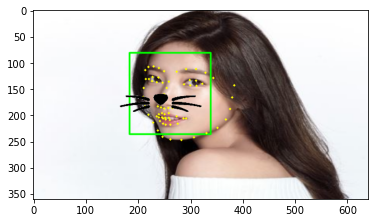

In [32]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

고양이 수염이 아주 귀엽게 장착이 되었네요

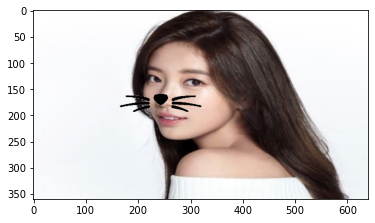

In [33]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

bounding box와 landmark를 제거하고 최종 결과만 출력해 완성되었습니다.
측면도 어려움 없이 잘 적용이 되는 것 같습니다.

#### 흑백 사진에 스티커 적용해보기

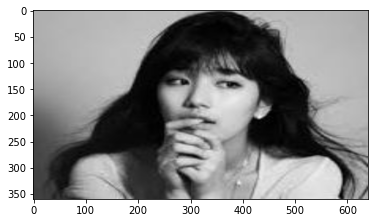

In [34]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/suji3.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

흑백 사진이라 그런지 컬러 이미지와는 다르게 색상의 변화가 없네요. 이미지 채널을 RGB(빨강, 녹색, 파랑) 으로 조정하는 과정을 생략하겠습니다.

### Step 2. 얼굴 검출 & 랜드마크 검출 하기

오늘 배운 dlib을 이용해서 얼굴의 bounding box 위치와 landmark의 위치를 찾아주세요.

In [35]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

🌫🛸


 이미지 밝기에 관계없이 이미지의 주요 특징들을 캡처한 HOG 패턴으로 바꿔줍니다.

In [36]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환해 주었습니다.

rectangles[]


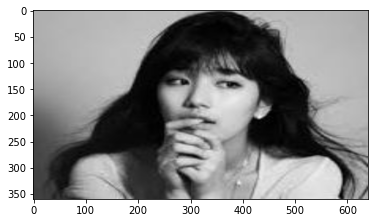

In [37]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

얼굴 영역 좌표가 나타나질 않아요 ㅠㅠ 제 생각엔 dlib_rect 라이브러리가 컬러만 인식하는게 아닐까 하는 생각이 들었습니다. 이걸 흑백도 인식하게 하려면 어떻게 해야 하는지는 더 공부해 봐야겠어요.

In [38]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


랜드마크 모델을 불러옵니다.

In [39]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

IndexError: list index out of range

역시 에러가 나네요. 랜드마크도 생성되지 않았습니다. 혹시나 해서 slack에 질문을 올렸더니 'landmark predict model이 칼라이미지로 학습을 하였기 때문에 랜드마크를 못 잡는 것 일수도 있어요.'라는 답변을 주셨네요. 저도 비슷하게 생각했습니다.

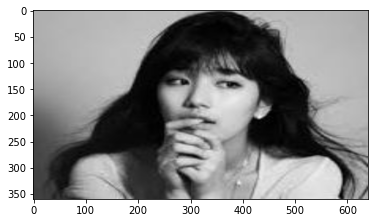

In [40]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

랜드마크는 생각대로 출력이 되지는 않았습니다. 그래도 흑백 사진에 왕관을 씌우신 분이 있는걸로 보아 랜드마크에 관계없이 스티커는 붙여볼수 있을것 같아 시도해 보겠습니다.

### Step 3. 스티커 적용 위치 확인하기

고양이 수염이 적용 될 볼 위치를 landmark를 사용해서 계산해 주세요.

In [41]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width() // 2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

In [42]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(156, 156, 3)


콧수염 이미지를 resize 합니다.

In [43]:
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (166,-62)


In [44]:
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(94, 156, 3)


원본이미지에 스티커 이미지를 추가하기 위해서 x,y 좌표를 조정합니다.

In [45]:
refined_y = 160
refined_x = 230
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (230,160)


x좌표 값을 지정해 주었습니다. 여러번 값을 변경해 보았는데 230이 제일 잘 맞았습니다.

In [46]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)


#refined_y:refined_y+img_stricker.shape[0]으로 sticker_area, img_show  


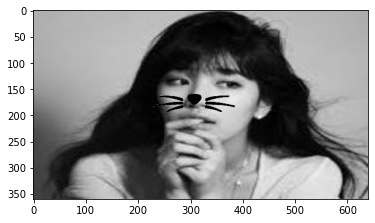

In [47]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

고양이 수염이 아주 귀엽게 장착이 되었네요
랜드마크를 설정해서 차원을 맞춰야 하는데 그냥 눈대중으로 콧수염만 붙인게 무슨의미인가 싶기도 하지만 어쨌든 콧수염이 생성되니 기분은 좋네요.^^
흑백 사진은 우리가 사용하는 모델에는 맞지 않는다는 걸 확인하는 걸로 만족하겠습니다.

## 총평

정말 이번과제 하면서 울뻔 했습니다. 공간지각력이 현저하게 떨어지는 저에겐 좌표를 이해하는 자체가 너무 어려웠습니다. 좌표가 이해가 안되니 고양이 콧수염을 코에 정확히 넣는 건 하늘의 별따기 였고, 그래도 팀원들과 화이트 보드를 그려가며 어떻게든 이해를 해보려 부단히 애를 썼네요. 얻어 걸려서 과제는 어찌어찌 해결했지만 정말 기본적인 용어부터 다시 숙지하고 개념을 확실하게 정리하는 작업이 절실하게 느껴졌습니다.
다들 너무 쉽게 해결하시는 것 같아 너무 좌절감이 들었어요 ㅜㅜ
그래도 콧수염이 달린 이미지를 보니 너무 감동입니다. 이걸 내가 해내다니...

일단 단 몇줄의 함수로 랜드마크를 찾아낸다는게 너무 신기했고 이런 과정을 거쳐 요즘 이미지어플들이 탄생 했겠구나 생각하니 신세계 같았습니다.
오늘도 또 한발걸음 디뎠네요. 